In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
from six.moves import cPickle as pickle
import cv2
import pickle
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, History

In [19]:
openDirs = ['data/eye-data/openLeftEyes', 'data/eye-data/openRightEyes']
closeDirs = ['data/eye-data/closedLeftEyes', 'data/eye-data/closedRightEyes']

In [20]:
def generate_dataset(type, dirData):
    dataset = np.ndarray([1231*2, 24, 24, 1], dtype='float32')
    i = 0
    for dir in dirData:
        for filename in os.listdir(dir):
            if filename.endswith('.jpg'):
                im = cv2.imread(dir + '/' + filename)
                # Convert to grayscale image
                im = np.dot(np.array(im, dtype='float32'), [[0.2989], [0.5870], [0.1140]]) / 255
                dataset[i, :, :, :] = im[:, :, :]
                i += 1

    if type == 1:
        labels = np.ones([len(dataset), 1], dtype=int)
    else:
        labels = np.zeros([len(dataset), 1], dtype=int)
    return dataset, labels

In [21]:
def save_train_and_test_set(dataset, labels, ratio, pickle_file):
    split = int(len(dataset) * ratio)
    train_dataset = dataset[:split]
    train_labels = labels[:split]
    test_dataset = dataset[split:]
    test_labels = labels[split:]

    try:
        f = open(pickle_file, 'wb')
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        }
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

    statinfo = os.stat(pickle_file)
    print('Compressed pickle size:', statinfo.st_size)

In [22]:
dataset_open, labels_open = generate_dataset(1, openDirs)
dataset_closed, labels_closed = generate_dataset(0, closeDirs)

ratio = 0.8

pickle_file_open = 'open_eyes.pickle'
pickle_file_closed = 'closed_eyes.pickle'

# Save open dataset to pickle file
save_train_and_test_set(dataset_open, labels_open, ratio, pickle_file_open)
# Save close dataset to pickle file
save_train_and_test_set(dataset_closed, labels_closed, ratio, pickle_file_closed)

Compressed pickle size: 5692535
Compressed pickle size: 5692535


In [23]:
np.random.seed(1337)  # for reproducibility

pickle_files = ['open_eyes.pickle', 'closed_eyes.pickle']
i = 0
for pickle_file in pickle_files:
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        if i == 0:
            train_dataset = save['train_dataset']
            train_labels = save['train_labels']
            test_dataset = save['test_dataset']
            test_labels = save['test_labels']
        else:
            train_dataset = np.concatenate((train_dataset, save['train_dataset']))
            train_labels = np.concatenate((train_labels, save['train_labels']))
            test_dataset = np.concatenate((test_dataset, save['test_dataset']))
            test_labels = np.concatenate((test_labels, save['test_labels']))
        del save  # hint to help gc free up memory
    i += 1

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (3938, 24, 24, 1) (3938, 1)
Test set (986, 24, 24, 1) (986, 1)


In [24]:
X_train = train_dataset
Y_train = train_labels
X_test = test_dataset
Y_test = test_labels

# print data shape
print("{1} train samples, {4} channel{0}, {2}x{3}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {4} channel{0}, {2}x{3}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

3938 train samples, 1 channels, 24x24
986  test samples, 1 channels, 24x24


In [25]:
_, img_channels, img_rows, img_cols = X_train.shape

model = Sequential()
# first	and	second Conv Layers with pooling
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_channels, img_rows, img_cols)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FC layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer. Define the class
model.add(Dense(1))
model.add(Activation('sigmoid'))

# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 24, 24, 32)        320       
_________________________________________________________________
activation_17 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)       

In [26]:
history = model.fit(X_train,
                    Y_train, 
                    batch_size=30, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(X_test, Y_test))

now = time.time()
print("Save model to file json...")
model_json = model.to_json()
with open('trained_model/model_' + str(now) + '.json', "w") as json_file:
    json_file.write(model_json)

print("Save weights to file...")
model.save_weights('trained_model/weight_' + str(now) + '.h5', overwrite=True)

Train on 3938 samples, validate on 986 samples
Epoch 1/50
3938/3938 [==============================] - 1s 259us/step - loss: 0.6720 - accuracy: 0.5777 - val_loss: 0.6412 - val_accuracy: 0.6298
Epoch 2/50
3938/3938 [==============================] - 1s 165us/step - loss: 0.6205 - accuracy: 0.6536 - val_loss: 0.6727 - val_accuracy: 0.5913
Epoch 3/50
3938/3938 [==============================] - 1s 152us/step - loss: 0.6127 - accuracy: 0.6607 - val_loss: 0.6193 - val_accuracy: 0.6653
Epoch 4/50
3938/3938 [==============================] - 1s 154us/step - loss: 0.5893 - accuracy: 0.6920 - val_loss: 0.5903 - val_accuracy: 0.6876
Epoch 5/50
3938/3938 [==============================] - 1s 170us/step - loss: 0.5108 - accuracy: 0.7605 - val_loss: 0.6766 - val_accuracy: 0.6663
Epoch 6/50
3938/3938 [==============================] - 1s 152us/step - loss: 0.3967 - accuracy: 0.8266 - val_loss: 0.3289 - val_accuracy: 0.8205
Epoch 7/50
3938/3938 [==============================] - 1s 155us/step - loss:

In [27]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Loss score:', score[0])
print('Test accuracy:', score[1] * 100, '%')

Loss score: 0.133695207096062
Test accuracy: 97.0588207244873 %


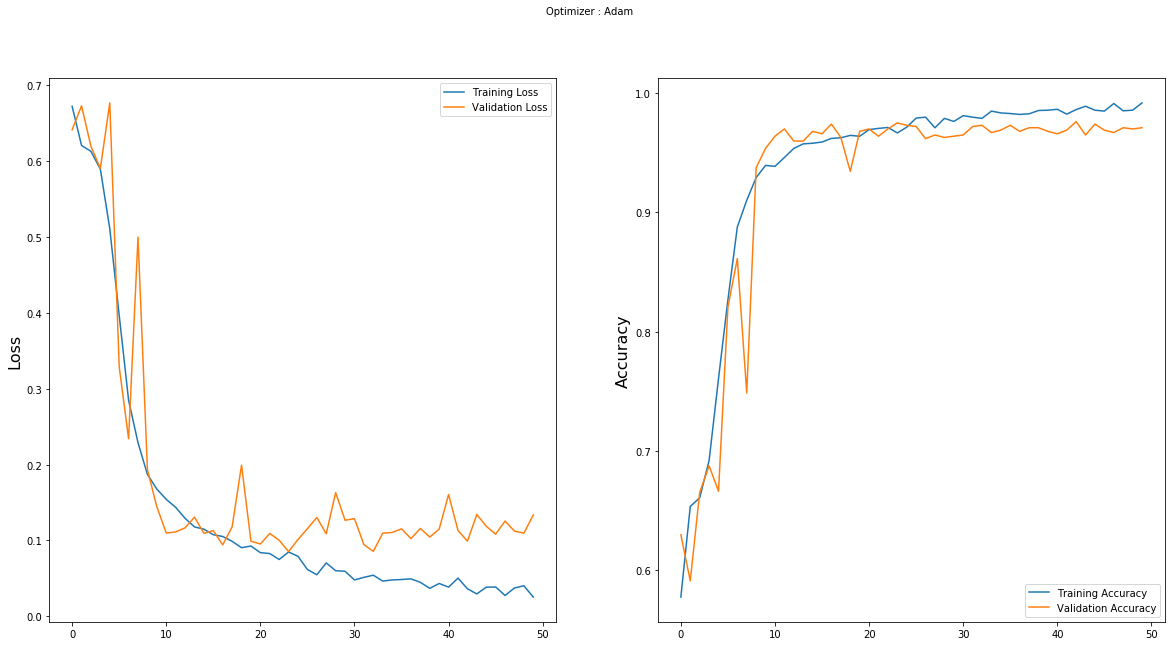

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()